In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import preprocess_input as Inception_preprocess
# Add my teamate's model together for ease of computation
from keras.applications.resnet50 import preprocess_input as Resnet_preprocess

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda, Dense, Input

from keras.callbacks import ModelCheckpoint 

from keras import optimizers
from keras import backend as K
from keras import regularizers

#from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files 
from tqdm import tqdm

# Add real time loss and accuracy plot
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


# Load and examine the dataset

In [3]:
def load_dataset(path):
    # the sklearn.datasets.load_files function takes a dataset directory as an input
    # for each folder within the directory, the folder name should be a category
    # within each folder will be samples corresponding to their category
    # load_files returns a bunch object which is a dictionary with 'DESC', 
    # 'data', 'filenames', 'target' as keys
    data = load_files(path)
    # an array of file paths or directories
    data_files = np.array(data['filenames']) 
    data_labels = np_utils.to_categorical(np.array(data['target']), 10)
    return data_files, data_labels

In [4]:
train_data_dir = "train/"
faked_data_dir = "faked/"
data_directory = faked_data_dir

In [5]:
train_files, train_labels = load_dataset(data_directory)
print("There are {} total training images.".format(len(train_files)))

There are 20 total training images.


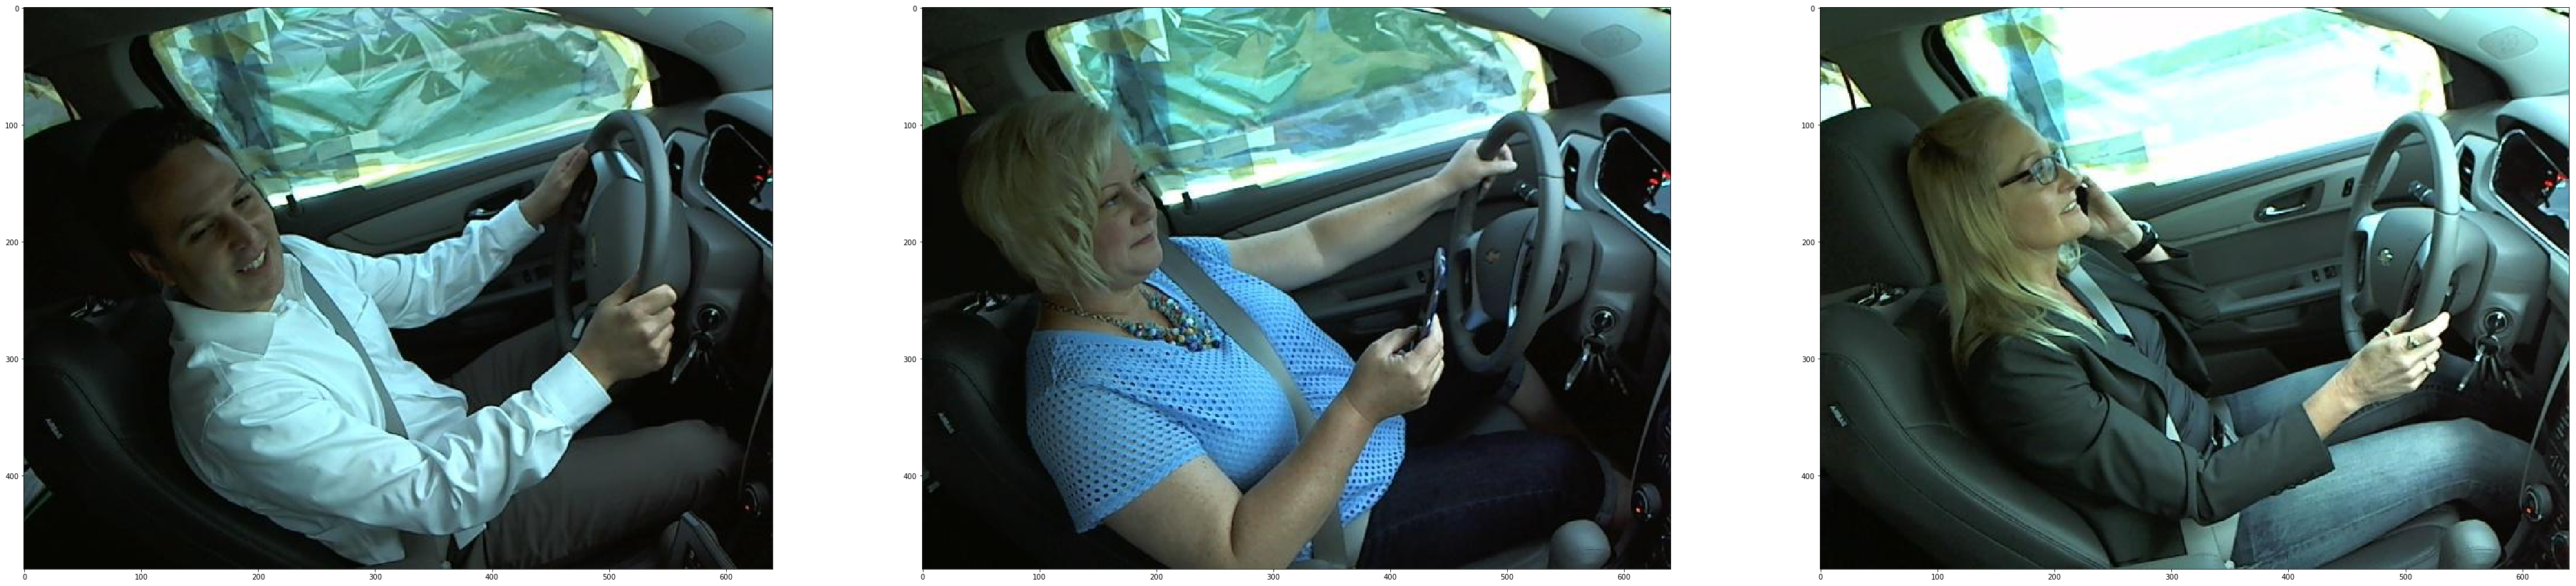

In [6]:
# Random visualize some image data
samples = np.random.choice(train_files, 3)
imgs = []
for sample in samples: 
    img = mpimg.imread(sample)
    imgs.append(img)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(64, 48))
ax1.imshow(imgs[0])
ax2.imshow(imgs[1])
ax3.imshow(imgs[2])
plt.show()

# Model building

<div class="alert alert-info">**Note:** In order to perform fine-tuning, all layers should start with properly trained weights: for instance you should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.
</div>

## ResNet50

In [8]:
# Hyperparameters setting
batch_size = 2
bottleneck_epochs = 2
finetune_epochs = 2
target_size = (224, 224)

In [9]:
train_valid_datagen = ImageDataGenerator(zoom_range=0.2, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   preprocessing_function=Resnet_preprocess, 
                                   validation_split=0.2)

In [10]:
# `subset` is only possible if `validation_split` is set
# make sure to seed the generator so both models would apply the same tranformation
train_generator = train_valid_datagen.flow_from_directory(data_directory, 
                                                    target_size=target_size, 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    subset="training",
                                                    shuffle=True,
                                                    seed=1)

Found 20 images belonging to 10 classes.


In [11]:
# `subset` is only possible if `validation_split` is set
validation_generator = train_valid_datagen.flow_from_directory(data_directory, 
                                                    target_size=target_size, 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    subset="validation",
                                                    shuffle=True,
                                                    seed=1)

Found 0 images belonging to 10 classes.


In [22]:
# Better provide the input shape to made the model summary more readible
input_tensor = Input(shape=(224, 224, 3))

ResNet50_base = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

x = ResNet50_base.output
x.shape
x = GlobalAveragePooling2D()(x) #1x1x2048
predictions = Dense(10, activation='softmax')(x)

ResNet50_model = Model(inputs=ResNet50_base.input, outputs=predictions)

# print out layer names to help decide where to unfreeze
for i, layer in enumerate(ResNet50_base.layers):
    print(i, layer.name)

for layer in ResNet50_base.layers:
    layer.trainable = False

ResNet50_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
add_71 (Add)                    (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_215[0][0]             
__________________________________________________________________________________________________
activation_218 (Activation)     (None, 28, 28, 512)  0           add_71[0][0]                     
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_218[0][0]             
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_240 (Activation)     (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_240[0][0]             
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_241 (Activation)     (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_241[0][0]             
__________

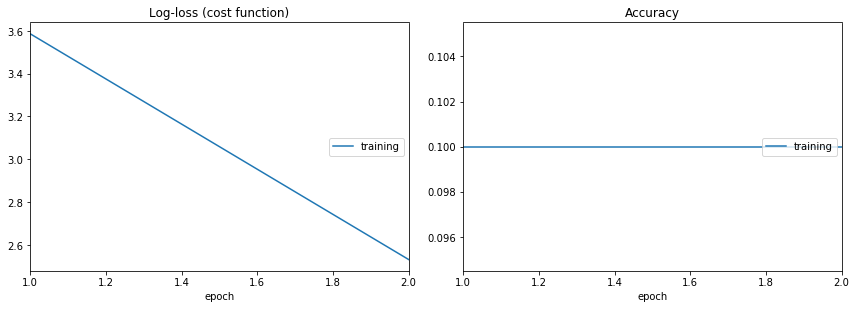

In [23]:
# Compile the mode, with optimizer as `rmsprop`
ResNet50_model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Set checkpointer for training callbacks
checkpointer = ModelCheckpoint(filepath='ResNet50_pretrain_weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Here I am ploting the losses and accuracy in real time
history = ResNet50_model.fit_generator(train_generator,
                    validation_data=validation_generator, 
                    epochs=bottleneck_epochs, 
                    callbacks=[checkpointer, PlotLossesKeras()], verbose=1)

### Finetuning ResNet50 model

In [ ]:
# In case the finetune process fails, run this line to start over
ResNet50_model.load_weights('ResNet50_pretrain_weights.best.hdf5')

In [ ]:
# The number need to choose by finetune

for layer in ResNet50_model.layers[:15]:
    layer.trainable = False
for layer in ResNet50_model.layers[15:]:
    layer.trainable=True

ResNet50_model.summary()

In [ ]:
# Train the model with SGD and small learning rate to REALLY FINETUNE
ResNet50_model.compile(optimizer=optimizers.SGD(lr=1e-5, momentum=0.5), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='ResNet50_finetune_weights.best.hdf5', 
                               verbose=0, save_best_only=True)

tuning_history = ResNet50_model.fit_generator(train_generator, 
                            epochs=finetune_epochs, 
                            validation_data=validation_generator, 
                            callbacks=[checkpointer, PlotLossesKeras()], 
                            verbose=0)

## InceptionV3

In [7]:
# Hyperparameters setting
batch_size = 2
bottleneck_epochs = 5
finetune_epochs = 5
target_size = (299, 299)

In [9]:
# Here I want to try real time data augumentation with keras
# `validation_split` is only support in Keras 2.2.0 
train_valid_datagen = ImageDataGenerator(zoom_range=0.2, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   preprocessing_function=Inception_preprocess, 
                                   validation_split=0.2)

In [10]:
# `subset` is only possible if `validation_split` is set
train_generator = train_valid_datagen.flow_from_directory(data_directory, 
                                                    target_size=target_size, 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    subset="training",
                                                    shuffle=True,
                                                    seed=1)

Found 20 images belonging to 10 classes.


In [11]:
# `subset` is only possible if `validation_split` is set
validation_generator = train_valid_datagen.flow_from_directory(data_directory, 
                                                    target_size=target_size, 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    subset="validation",
                                                    shuffle=True,
                                                    seed=1)

Found 0 images belonging to 10 classes.


In [24]:
# Better provide the input shape to made the model summary more readible
input_tensor = Input(shape=(299, 299, 3))

InceptionV3_base = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)

x = InceptionV3_base.output
# The input shape from bottleneck_feature is (data_size, 8, 8, 2048)
x = GlobalAveragePooling2D()(x) #1x1x2048
#x = Dense(512, activation='relu')(x) #1x1x512
predictions = Dense(10, activation='softmax')(x) #1x1x10

InceptionV3_model = Model(inputs=InceptionV3_base.input, outputs=predictions)

for layer in InceptionV3_base.layers:
    layer.trainable = False

# print out layer names to help decide where to unfreeze
for i, layer in enumerate(InceptionV3_base.layers):
    print(i, layer.name)

InceptionV3_model.summary()

0 input_6
1 conv2d_1
2 batch_normalization_1
3 activation_246
4 conv2d_2
5 batch_normalization_2
6 activation_247
7 conv2d_3
8 batch_normalization_3
9 activation_248
10 max_pooling2d_6
11 conv2d_4
12 batch_normalization_4
13 activation_249
14 conv2d_5
15 batch_normalization_5
16 activation_250
17 max_pooling2d_7
18 conv2d_9
19 batch_normalization_9
20 activation_254
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_252
26 activation_255
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_251
37 activation_253
38 activation_256
39 activation_257
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_261
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_259
49 activation_262
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normali

activation_262 (Activation)     (None, 35, 35, 96)   0           batch_normalization_17[0][0]     
__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 35, 35, 256)  0           mixed0[0][0]                     
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 35, 35, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 35, 35, 64)   76800       activation_259[0][0]             
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 35, 35, 96)   82944       activation_262[0][0]             
__________________________________________________________________________________________________
conv2d_19 

batch_normalization_40 (BatchNo (None, 17, 17, 192)  576         conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_276 (Activation)     (None, 17, 17, 192)  0           batch_normalization_31[0][0]     
__________________________________________________________________________________________________
activation_279 (Activation)     (None, 17, 17, 192)  0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
activation_284 (Activation)     (None, 17, 17, 192)  0           batch_normalization_39[0][0]     
__________________________________________________________________________________________________
activation_285 (Activation)     (None, 17, 17, 192)  0           batch_normalization_40[0][0]     
__________________________________________________________________________________________________
mixed4 (Co

__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 17, 17, 192)  576         conv2d_62[0][0]                  
__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, 17, 17, 192)  576         conv2d_67[0][0]                  
__________________________________________________________________________________________________
activation_307 (Activation)     (None, 17, 17, 192)  0           batch_normalization_62[0][0]     
__________________________________________________________________________________________________
activation_312 (Activation)     (None, 17, 17, 192)  0           batch_normalization_67[0][0]     
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 17, 17, 192)  258048      activation_307[0][0]             
__________

__________________________________________________________________________________________________
activation_335 (Activation)     (None, 8, 8, 448)    0           batch_normalization_90[0][0]     
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 8, 8, 384)    786432      mixed9[0][0]                     
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 8, 8, 384)    1548288     activation_335[0][0]             
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, 8, 8, 384)    1152        conv2d_87[0][0]                  
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, 8, 8, 384)    1152        conv2d_91[0][0]                  
__________

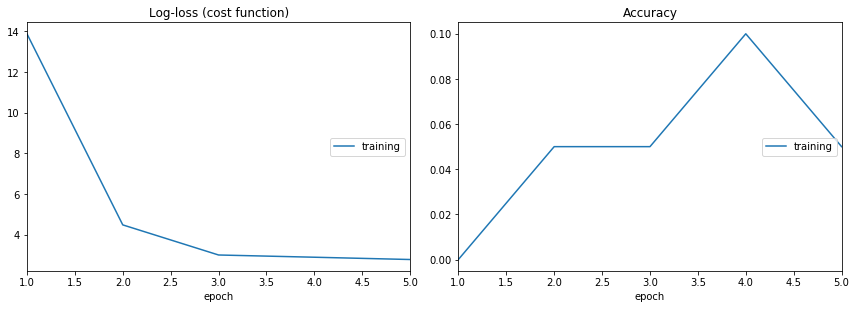

In [14]:
# Compile the mode, with optimizer as `rmsprop`
InceptionV3_model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Set checkpointer for training callbacks
checkpointer = ModelCheckpoint(filepath='InceptionV3_pretrain_weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Here I am ploting the losses and accuracy in real time
history = InceptionV3_model.fit_generator(train_generator,
                    validation_data=validation_generator, 
                    epochs=bottleneck_epochs, 
                    callbacks=[checkpointer, PlotLossesKeras()], 
                    verbose=0)

# Finetuning the InceptionV3 model 

I run into [this link](https://keras.io/applications/) and rewrite my finetuning model as below

In [ ]:
# In case the finetune process fails, run this line to start over
InceptionV3_model.load_weights('InceptionV3_pretrain_weights.best.hdf5')

In [ ]:
for layer in InceptionV3_model.layers[:249]:
    layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
    layer.trainable=True

InceptionV3_model.summary()

In [ ]:
# Train the model with SGD and small learning rate to REALLY FINETUNE
InceptionV3_model.compile(optimizer=optimizers.SGD(lr=1e-5, momentum=0.5), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='InceptionV3_finetune_weights.best.hdf5', 
                               verbose=0, save_best_only=True)

tuning_history = InceptionV3_model.fit_generator(train_generator, 
                            epochs=finetune_epochs, 
                            validation_data=validation_generator, 
                            callbacks=[checkpointer, PlotLossesKeras()], 
                            verbose=0)

## Ensemble models

I personally don't like the idea of Ensemble since it is more of a competition wining skills which only add the complexity of the model and can hardly be used in production. However, as a learning experience, I want to give it a try. 

In [8]:
# Helper functions to process the test data
def path_to_tensor(img_path, target_size=target_size):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, target_size=target_size):
    list_of_tensors = [path_to_tensor(path, target_size=target_size) for path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
from glob import glob
from collections import defaultdict
import pandas as pd

img_names = [item[5:] for item in sorted(glob('test/*'))]
img_directory = [item for item in sorted(glob('test/*'))]

Inception_data = paths_to_tensor(img_directory, target_size=(299, 299))
Resnet50_data = paths_to_tensor(img_directory, target_size=(224, 224))

Inception_input = Inception_preprocess(Inception_data)
Resnet50_input = Resnet_preprocess(Resnet50_data)

In [ ]:
# Obtain the ensembled predictions

predictions = defaultdict(np.array)

for img_name, inception, resnet in zip(img_names, Inception_input, Resnet50_input):
    Inception_output = InceptionV3_model.predict(np.expand_dims(inception, 0))
    Resnet_output = ResNet50_model.predict(np.expand_dims(inception, 0))
    ensembled = np.mean(np.vstack((Inception_output, Resnet_output)), axis=0)
    predictions[img_name] = ensembled

In [ ]:
# Write out the data according to submission request format

data = pd.DataFrame(predictions, index=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
data = data.transpose()
data

In [ ]:
data.to_csv("my data.csv")